In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os 
from scipy.spatial import distance
from scipy import ndimage
from skimage import measure
from scipy import stats

%matplotlib inline

# _Pre-defined_ parameters

In [2]:
params={}

#####################################################
# Parameters for intensity (fixed)
#####################################################

params['lungMinValue']      = -1024
params['lungMaxValue']      = -400
params['lungThreshold']     = -900

#####################################################
# Parameters for lung segmentation (fixed)
#####################################################

params['xRangeRatio1']      = 0.4
params['xRangeRatio2']      = 0.75
params['zRangeRatio1']      = 0.5
params['zRangeRatio2']      = 0.75

#####################################################
# Parameters for airway segmentation
# NEED TO ADAPT for image resolution and orientation 
#####################################################
params['airwayRadiusMask']  = 15  # increase the value if you have high resolution image
params['airwayRadiusX']     = 8   # ditto
params['airwayRadiusZ']     = 15  # ditto
params['super2infer']       = 0   # value = 1 if slice no. increases from superior to inferior, else value = 0

# _Pre-defined_ functions

In [3]:
#####################################################
# Generate binary structure to mimic trachea
#####################################################

def generate_structure_trachea(Radius,RadiusZ):
    
    struct_trachea = np.zeros([2*Radius+1,2*Radius+1,RadiusZ])
    for i in range(0,2*Radius+1):
        for j in range(0,2*Radius+1):
            if distance.euclidean([Radius+1,Radius+1],[i,j]) < RadiusX:
                struct_trachea[i,j,:] = 1
            else:
                struct_trachea[i,j,:] = 0
    
    return struct_trachea

#####################################################
# Generate bounding box
#####################################################

def bbox2_3D(img,label,margin,limit):
    
    imgtmp = np.zeros(img.shape)
    imgtmp[img == label] = 1
    
    x = np.any(imgtmp, axis=(1, 2))
    y = np.any(imgtmp, axis=(0, 2))
    z = np.any(imgtmp, axis=(0, 1))

    xmin, xmax = np.where(x)[0][[0, -1]]
    ymin, ymax = np.where(y)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    xmin = xmin - margin - 1
    xmin = max(0,xmin)
    ymin = ymin - margin - 1
    ymin = max(0,ymin)
    zmin = zmin - margin - 1
    zmin = max(0,zmin)        
    xmax = xmax + margin + 1
    xmax = min(xmax,limit[0])
    ymax = ymax + margin + 1
    ymax = min(ymax,limit[1])
    zmax = zmax + margin + 1
    zmax = min(zmax,limit[2])
        
    return xmin, xmax, ymin, ymax, zmin, zmax

# _Coarse_ lung & airway segmentation
1. Intensity thresholding and morphological operations;
2. Select the largest connected components in estimated lung filed of view.

(-0.5, 271.5, 239.5, -0.5)

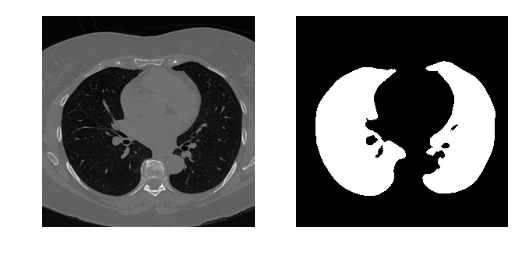

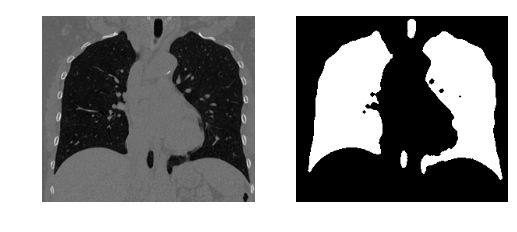

In [4]:
#####################################################
# Load image 
#####################################################
I         = nib.load('./data/sample_ct.nii.gz')
I_affine  = I.affine
I         = I.get_data()

#####################################################
# Intensity thresholding & Morphological operations
#####################################################

M = np.zeros(I.shape)
M[I > params['lungMinValue']]=1
M[I > params['lungMaxValue']]=0

struct_s = ndimage.generate_binary_structure(3, 1)
struct_m = ndimage.iterate_structure(struct_s, 2)
M = ndimage.binary_closing(M, structure=struct_s, iterations=1)
M = ndimage.binary_opening(M, structure=struct_m, iterations=1)

#####################################################
# Estimate lung filed of view
#####################################################

[m, n, p] = I.shape;
medx      = int(m/2)
medy      = int(n/2)
xrange1   = int(m/2*params['xRangeRatio1'])
xrange2   = int(m/2*params['xRangeRatio2'])
zrange1   = int(p*params['zRangeRatio1'])
zrange2   = int(p*params['zRangeRatio2'])

#####################################################
# Select largest connected components & save nii
#####################################################

M = measure.label(M)
label1 = M[medx-xrange2:medx-xrange1,medy,zrange1:zrange2]
label2 = M[medx+xrange1:medx+xrange2,medy,zrange1:zrange2]
label1 = stats.mode(label1[label1 > 0])[0][0]
label2 = stats.mode(label2[label2 > 0])[0][0]
M[M == label1] = -1
M[M == label2] = -1
M[M > 0] = 0
M = M*-1

M     = ndimage.binary_closing(M, structure = struct_m, iterations = 1)
M     = ndimage.binary_fill_holes(M)
Mlung = np.int8(M)
nib.Nifti1Image(Mlung,I_affine).to_filename('./result/sample_lungaw.nii.gz')

#####################################################
# Display segmentation results 
#####################################################

plt.figure(1)
slice_no = int(p/2)
plt.subplot(121)
plt.imshow(np.fliplr(np.rot90(I[:,:,slice_no])),cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.imshow(np.fliplr(np.rot90(Mlung[:,:,slice_no])),cmap=plt.cm.gray)
plt.axis('off')

plt.figure(2)
slice_no = int(n*0.5)
plt.subplot(121)
plt.imshow(np.fliplr(np.rot90(I[:,slice_no,:])),cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.imshow(np.fliplr(np.rot90(Mlung[:,slice_no,:])),cmap=plt.cm.gray)
plt.axis('off')

# Romove airway from lung mask
1. Locate an inital point of the airway;
2. Segment airway with closed space diallation.

initial location = [122, 133, 237]
iter = 1 airway sum = 3077 airway change = 1239
iter = 2 airway sum = 4309 airway change = 1232
iter = 3 airway sum = 5548 airway change = 1239
iter = 4 airway sum = 6616 airway change = 1068
iter = 5 airway sum = 7459 airway change = 843
iter = 6 airway sum = 8296 airway change = 837
iter = 7 airway sum = 9150 airway change = 854
iter = 8 airway sum = 9993 airway change = 843
iter = 9 airway sum = 10920 airway change = 927
iter = 10 airway sum = 11913 airway change = 993
iter = 11 airway sum = 12998 airway change = 1085
iter = 12 airway sum = 14176 airway change = 1178
iter = 13 airway sum = 15172 airway change = 996
iter = 14 airway sum = 16150 airway change = 978
iter = 15 airway sum = 17117 airway change = 967
iter = 16 airway sum = 17955 airway change = 838
iter = 17 airway sum = 18842 airway change = 887
iter = 18 airway sum = 19773 airway change = 931
iter = 19 airway sum = 20557 airway change = 784
iter = 20 airway sum = 21078 airway change = 

(-0.5, 271.5, 239.5, -0.5)

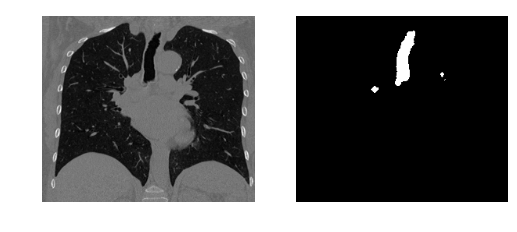

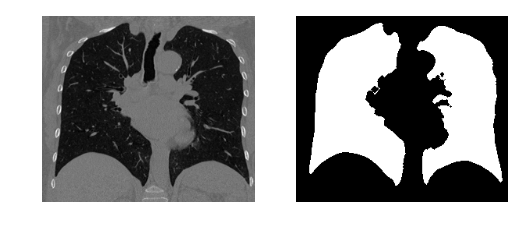

In [5]:
#####################################################
# Initialize parameters 
#####################################################

valueAirwayMin = ['lungMinValue'];
valueAirwayMax = params['lungThreshold']
Radius         = params['airwayRadiusMask']
RadiusX        = params['airwayRadiusX']
RadiusZ        = params['airwayRadiusZ']
mind           = np.argwhere(Mlung == 1)
minDiff        = float('inf')
initLoc        = [0,0,0];
struct_trachea = generate_structure_trachea(Radius,RadiusZ)
            
#####################################################
# Locate an inital point in trachea 
#####################################################

if params['super2infer']:
    slice_no  = np.min(mind[:,2])
    Itmp      = I[:,:,slice_no:slice_no+RadiusZ]
else:
    slice_no  = np.max(mind[:,2])
    Itmp      = I[:,:,slice_no-RadiusZ:slice_no]
    
Mtmp = np.ones(Itmp.shape);
Mtmp[Itmp < params['lungMinValue']] = 0
Mtmp[Itmp > params['lungMaxValue']] = 0
Itmp = Mtmp;
Mtmp = np.sum(Mtmp, axis = 2)

for i in range(Radius, Itmp.shape[0]-Radius):
    for j in range(Radius, Itmp.shape[1]-Radius):
        if Mtmp[i,j] > 0:   
            struct_Itmp = Itmp[i-Radius:i+Radius+1,j-Radius:j+Radius+1,:]
            currVal     = struct_Itmp - struct_trachea
            currVal     = np.sum(np.square(currVal))
            
            if currVal  < minDiff:
                initLoc = [i,j,slice_no]
                minDiff = currVal

print 'initial location = '+str(initLoc)

#####################################################
# Find airway with closed space diallation
#####################################################

iterNoPerSlice = RadiusX
maxFactor      = RadiusX/2
maxChange      = RadiusX*RadiusX*RadiusX*50
totalChange    = 1
tempCheck      = 0

Mtmp = np.zeros([m,n,p])
if params['super2infer']:
    Mtmp[initLoc[0]-Radius:initLoc[0]+Radius+1,
         initLoc[1]-Radius:initLoc[1]+Radius+1,
         0:slice_no+RadiusZ] = 1
else:
    Mtmp[initLoc[0]-Radius:initLoc[0]+Radius+1,
         initLoc[1]-Radius:initLoc[1]+Radius+1,
         slice_no-RadiusZ:p-1] = 1
Mtmp  = np.multiply(Mtmp, Mlung)
Minit = ndimage.binary_closing(Mtmp, structure = struct_s, iterations = 1)
Minit = np.int8(Minit)
Minit[Minit > 0] = 2 

while totalChange > 0:
    
    maxSegmentChange = 0;
    tempCheck        = tempCheck + 1     
    L                = measure.label(np.floor(Minit/2))
    Minit[Minit > 1] = 1  
                
    for label in np.unique(L[:]):
        
        if label != 0 and np.sum(L[:] == label) > 10:
            
            # Process each component in local FOV 
            
            xmin, xmax, ymin, ymax, zmin, zmax = bbox2_3D(L,label,iterNoPerSlice,[m,n,p])                                       
            Mtmp                = Minit[xmin:xmax,ymin:ymax,zmin:zmax]
            Itmp                = I[xmin:xmax,ymin:ymax,zmin:zmax]
            Ltmp                = L[xmin:xmax,ymin:ymax,zmin:zmax]
            Ltmp[Ltmp != label] = 0
            Ltmp[Ltmp > 0]      = 1;

            for iterCount in range(0, iterNoPerSlice):
                Ltmp = ndimage.binary_dilation(Ltmp, structure = struct_s, iterations = 1)
                Ltmp = np.int8(Ltmp)
                Ltmp[Itmp > valueAirwayMax] = 0                

            Ltmp = ndimage.binary_closing(Ltmp, structure = struct_s, iterations = 1)
            Ltmp = np.int8(Ltmp)
            Ltmp[Mtmp > 0] = 0
            Ltmp[Ltmp > 0] = 2
            Ltmp = Ltmp + Mtmp

            segmentChange = np.sum(Ltmp[:]>1)        
            if segmentChange < maxChange or tempCheck < 10:
                Minit[xmin:xmax,ymin:ymax,zmin:zmax] = Ltmp
                if segmentChange > maxSegmentChange:
                    maxSegmentChange = segmentChange

    if tempCheck < 10:
        maxChange = max(maxFactor*maxSegmentChange,maxChange)
    else:        
        maxChange = min(maxFactor*maxSegmentChange,maxChange)
    
    totalChange = np.sum(Minit[:]>1)
    
    print 'iter = '+str(tempCheck)+' airway sum = '+str(np.sum(Minit[:]>0))\
                        +' airway change = '+str(totalChange)

#####################################################
# Remove airway & save nii
#####################################################

Minit[Minit > 0] = 1
Minit = ndimage.binary_opening(Minit, structure = struct_s, iterations = 1)
Minit = ndimage.binary_dilation(Minit, structure = struct_m, iterations = 1)
Minit = np.int8(Minit)
Maw   = Minit
Mlung[Maw > 0] = 0
nib.Nifti1Image(Maw,I_affine).to_filename('./result/sample_aw.nii.gz')
nib.Nifti1Image(Mlung,I_affine).to_filename('./result/sample_lung.nii.gz')

#####################################################
# Display segmentation results 
#####################################################

plt.figure(1)
slice_no = int(n*0.45)
plt.subplot(121)
plt.imshow(np.fliplr(np.rot90(I[:,slice_no,:])),cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.imshow(np.fliplr(np.rot90(Maw[:,slice_no,:])),cmap=plt.cm.gray)
plt.axis('off')

plt.figure(2)
slice_no = int(n*0.45)
plt.subplot(121)
plt.imshow(np.fliplr(np.rot90(I[:,slice_no,:])),cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.imshow(np.fliplr(np.rot90(Mlung[:,slice_no,:])),cmap=plt.cm.gray)
plt.axis('off')